In [60]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_log_error, make_scorer, mean_squared_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score,train_test_split

from sklearn.linear_model import RidgeCV, Ridge, LinearRegression, RidgeCV, Ridge
from sklearn.datasets import make_regression

from csv_reader import *
from csv_setup import *

bike_sharing_df = get_bike_sharing_df_clean()
plt.rcParams.update({'font.size': 18})

In [61]:
def rmsle(y_log, y0_log):
    return np.sqrt(np.mean(np.square(y_log - y0_log)))

In [62]:
# Train and test data preperation
# We split the data first, then we take the log of the cnt, which represents the number of bikes on a given day

scaler = StandardScaler()

# Count variable that we are going to be predicting
Y = bike_sharing_df.cnt
# Features that we are going to be fitting
X = bike_sharing_df.loc[:].drop(columns=["cnt"])

# Split the data
X_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.33, random_state = 1)



# log of each of the cnt
# this will normalize the variable that we are trying to predict
y_train_log = y_train.apply(lambda x:np.log1p(x))
y_test_log = y_test.apply(lambda x:np.log1p(x))

# y_train_log = y_train
# y_test_log = y_test

X_train = scaler.fit_transform(X_train)
x_test = scaler.fit_transform(x_test)


# y_test = y_test.reset_index().drop('index',axis = 1)
# y_train = y_train.reset_index().drop('index',axis = 1)

parameters = {
         'max_iter':[5000],        
         'alpha':np.logspace(0, 9, 100),
         'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    }


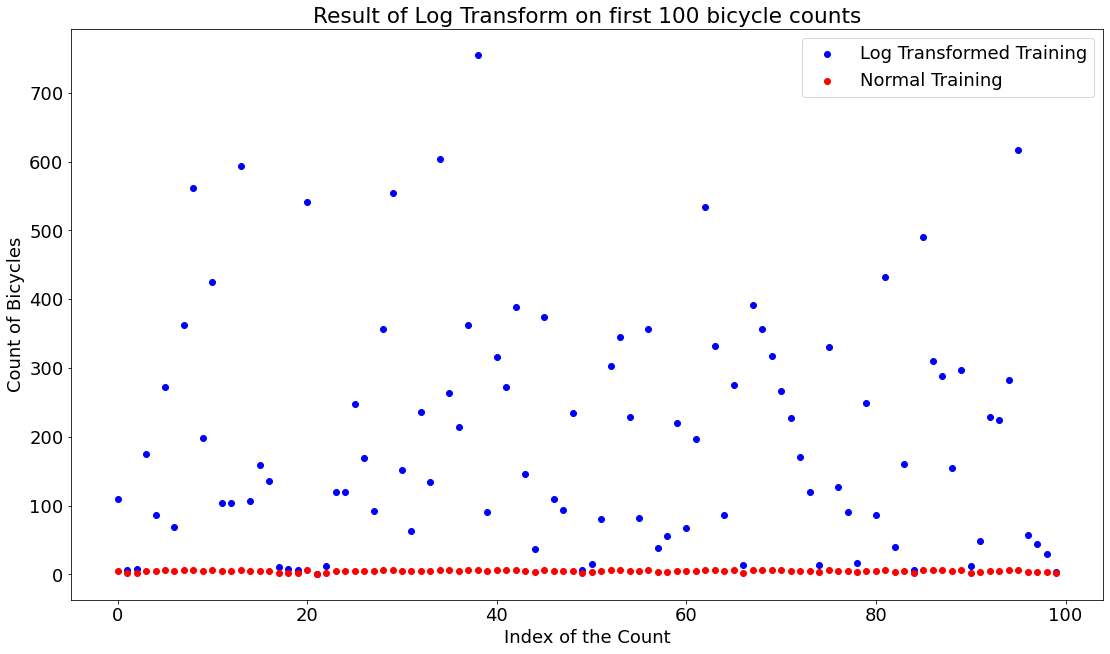

In [63]:
plt.figure()
xvalues = []
i = 0
for a in range(0, 100):
    xvalues.append(a)
    i = i+1
    
plt.scatter(xvalues,y_train[:100],color="blue", label="Normal Training")
plt.scatter(xvalues,y_train_log[:100],color="red", label="Log Transformed Training")
ax = plt.gca()
plt.gcf().set_size_inches(18.5, 10.5)

ax.legend(("Log Transformed Training", "Normal Training"))
plt.xlabel('Index of the Count')
plt.ylabel('Count of Bicycles')
plt.title('Result of Log Transform on first 100 bicycle counts')
plt.show()

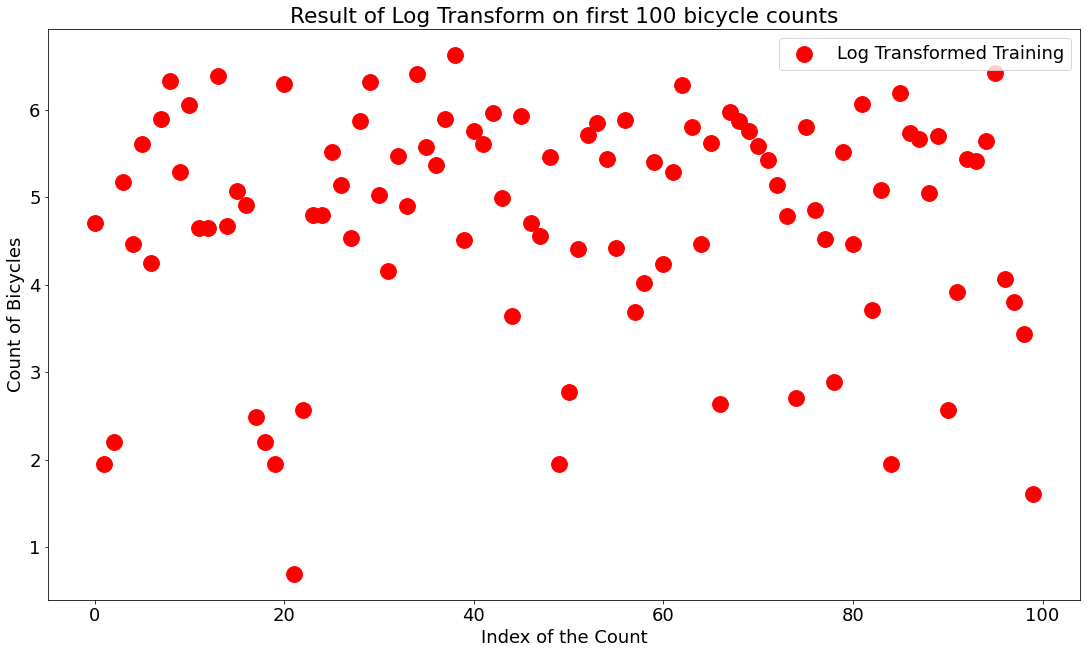

In [77]:
plt.figure()
xvalues = []
i = 0
for a in range(0, 100):
    xvalues.append(a)
    i = i+1
    
plt.scatter(xvalues,y_train_log[:100],s=250,color="red", label="Log Transformed Training")
ax = plt.gca()
plt.gcf().set_size_inches(18.5, 10.5)

ax.legend(("Log Transformed Training", "Normal Training"))
plt.xlabel('Index of the Count')
plt.ylabel('Count of Bicycles')
plt.title('Result of Log Transform on first 100 bicycle counts')
plt.show()

In [65]:
# This function uses the log of the count values, this will enable us to calculate the RMSLE
# The worry here being that the MSE is now artificially low as the variance will decrease because of 
#      the log transformation

def RidgeLog(x_train, y_train):
    # Here we are cross validating as well as fitting the model
    # We are using the neg_mean_squared_log_error to find the best alpha
    gs = GridSearchCV(Ridge(),refit=True, param_grid = parameters, scoring='neg_mean_squared_error', cv=5)
    gs.fit(X_train,y_train)

    return gs

In [66]:
# This function uses the original count values
# The MSE will be extremely high

def RidgeNormal(x_train, y_train):
    # 0-9 to show all iterations that are done
    # Now we are using just the neg_mean_squared_error to find the best coeff
    gs = GridSearchCV(Ridge(),refit=True, param_grid = parameters, scoring='neg_mean_squared_error', cv=5)
    gs.fit(X_train,y_train)
    return gs

In [67]:
gsRidgeLog = RidgeLog(X_train, y_train_log)
gsRidge = RidgeNormal(X_train, y_train)



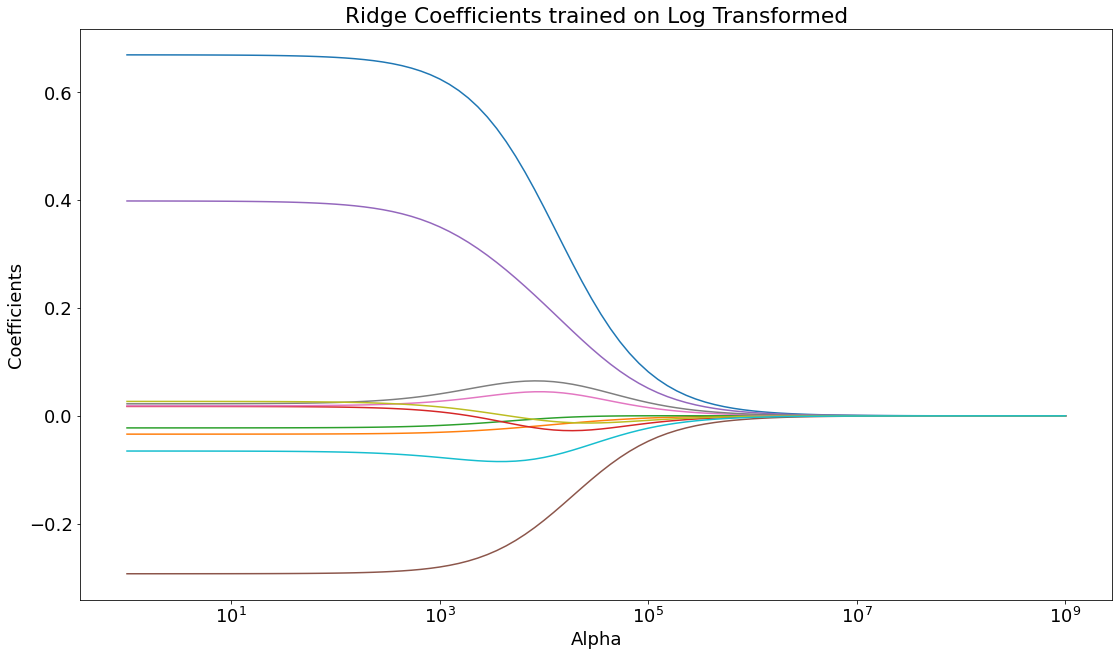

In [68]:
coefs = []
pipe = Ridge()

for a in parameters['alpha']:
        pipe.alpha = a
        pipe.fit(X_train, y_train_log)
        coefs.append(pipe.coef_)

plt.figure()
plt.gcf().set_size_inches(18.5, 10.5)

ax = plt.gca()
ax.plot(parameters['alpha'], coefs)
ax.set_xscale('log')

plt.title('Ridge Coefficients trained on Log Transformed')
plt.axis('tight')
plt.xlabel('Alpha')
plt.ylabel('Coefficients');

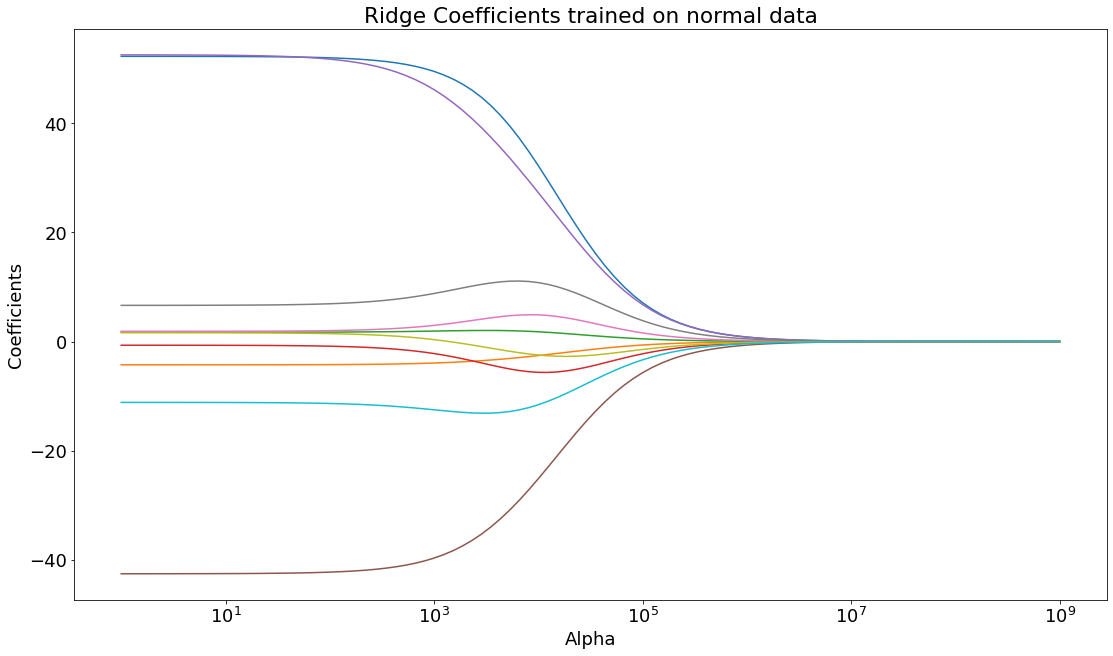

In [69]:
coefs = []
pipe = Ridge()

for a in parameters['alpha']:
        pipe.alpha = a
        pipe.fit(X_train, y_train)
        coefs.append(pipe.coef_)

plt.figure().clear()
ax = plt.gca()
ax.plot(parameters['alpha'], coefs)
ax.set_xscale('log')
plt.gcf().set_size_inches(18.5, 10.5)

plt.title('Ridge Coefficients trained on normal data')
plt.axis('tight')
plt.xlabel('Alpha')
plt.ylabel('Coefficients');


In [70]:
print("Best alpha Log: " + str(gsRidgeLog.best_params_['alpha']))
print("Best coeff Log: " + str(gsRidgeLog.best_estimator_.coef_))

print("\nBest alpha Normal: " + str(gsRidge.best_params_['alpha']))
print("Best coeff Normal: " + str(gsRidge.best_estimator_.coef_))



Best alpha Log: 23.101297000831604
Best coeff Log: [ 0.6683237  -0.0333454  -0.02202813  0.01728252  0.39712867 -0.29267814
  0.01857308  0.02288315  0.0265355  -0.06570314]

Best alpha Normal: 28.48035868435802
Best coeff Normal: [ 52.23991118  -4.25264763   1.66983027  -0.71191053  52.33228753
 -42.53072757   1.90768931   6.71345191   1.56063908 -11.21646851]


In [71]:
# Average of Y's
np.mean(y_train_log)

4.5717683471239114

In [72]:
print('\nCoefficients  [ridge] Log')

yvalues1 = gsRidgeLog.best_estimator_.coef_

for i in range(0,10):
    print('   Feature %f:  %.2f'%(i,\
                    yvalues1[i]))

print('\nCoefficients  [ridge] Normal')

yvalues2 = gsRidge.best_estimator_.coef_
for i in range(0,10):
    print('   Feature %f:  %.2f'%(i,\
                    yvalues2[i]))
    
xvalues = [1,2,3,4,5,6,7,8,9,10]
   


Coefficients  [ridge] Log
   Feature 0.000000:  0.67
   Feature 1.000000:  -0.03
   Feature 2.000000:  -0.02
   Feature 3.000000:  0.02
   Feature 4.000000:  0.40
   Feature 5.000000:  -0.29
   Feature 6.000000:  0.02
   Feature 7.000000:  0.02
   Feature 8.000000:  0.03
   Feature 9.000000:  -0.07

Coefficients  [ridge] Normal
   Feature 0.000000:  52.24
   Feature 1.000000:  -4.25
   Feature 2.000000:  1.67
   Feature 3.000000:  -0.71
   Feature 4.000000:  52.33
   Feature 5.000000:  -42.53
   Feature 6.000000:  1.91
   Feature 7.000000:  6.71
   Feature 8.000000:  1.56
   Feature 9.000000:  -11.22


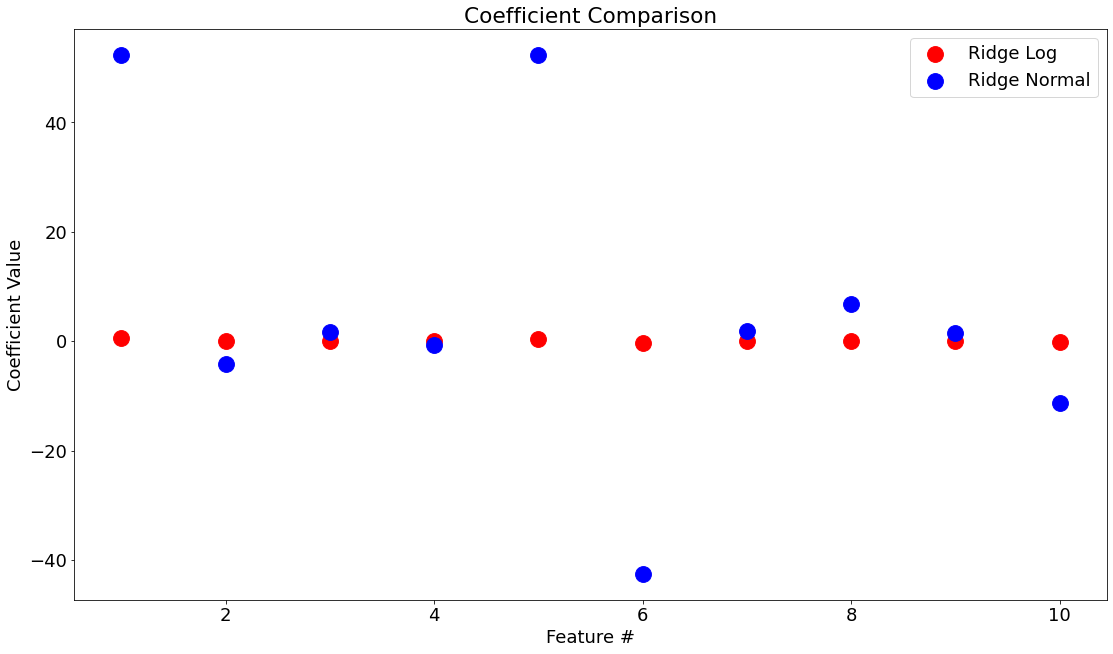

In [73]:
# This is a plot showing the difference between the coefficient values.
# The largest difference being between the value of the coefficients for features 5 and 6

plt.figure()

plt.scatter(xvalues,yvalues1,s=250,color="red", label="Ridge Log")
plt.scatter(xvalues,yvalues2, s=250,color="blue", label="Ridge Normal")
ax = plt.gca()
plt.gcf().set_size_inches(18.5, 10.5)

ax.legend(("Ridge Log", "Ridge Normal"))
plt.xlabel('Feature #')
plt.ylabel('Coefficient Value')
plt.title('Coefficient Comparison')
plt.show()

In [78]:
y_pred = gsRidgeLog.predict(x_test)

mse_test_using_ridge = mean_squared_error(y_test_log,y_pred)
print('\nTest set MSE using Log Ridge coefficients: %.2f'%mse_test_using_ridge)
print('Test set RMLSE using Log Ridge coefficients %.2f'%rmsle(y_test_log, y_pred))


# One reason for the MSE being unreasonably high here is the high variance in the data
# Compared to that of the log transformed MSE of the Log Ridge
y_pred = gsRidge.predict(x_test)
mse_test_using_ridge = mean_squared_error(y_test,y_pred)
print('\nTest set MSE using ridge coefficients: %.2f'%mse_test_using_ridge)
print('Once again, we cannot use the normal Ridge coefficients to calculate RMLSE because it predicts negative numbers')


Test set MSE using Log Ridge coefficients: 1.11
Test set RMLSE using Log Ridge coefficients 1.05

Test set MSE using ridge coefficients: 22852.57
Once again, we cannot use the normal Ridge coefficients to calculate RMLSE because it predicts negative numbers


In [75]:
lm = gsRidgeLog

y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(x_test)


print('R squared statistic for Log Ridge')
print('Train Score: ')
print(r2_score(y_train_log, y_train_pred))

print('\nTest Score: ')
print(r2_score(y_test_log, y_test_pred))

R squared statistic for Log Ridge
Train Score: 
0.4562448786258887

Test Score: 
0.4532889973670685


In [76]:
lm = gsRidge

y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(x_test)

print('R squared statistic for Normal Ridge')

print('Train Score: ')
print(r2_score(y_train, y_train_pred))

print('\nTest Score: ')
print(r2_score(y_test, y_test_pred))

R squared statistic for Normal Ridge
Train Score: 
0.33007927030795803

Test Score: 
0.33081408593293515
